In [1]:
import os
import pickle as pkl
from matplotlib import pyplot as plt
import time
import imageio
import numpy as np
from tqdm import tqdm
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam

timesteps = []
torques = []
tau_ests = []
tau_preds = []

class ActuatorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['joint_states'])

    def __getitem__(self, idx):
        return {k: v[idx] for k,v in self.data.items()}

class Act(nn.Module):
  def __init__(self, act, slope=0.05):
    super(Act, self).__init__()
    self.act = act
    self.slope = slope
    self.shift = torch.log(torch.tensor(2.0)).item()

  def forward(self, input):
    if self.act == "relu":
      return F.relu(input)
    elif self.act == "leaky_relu":
      return F.leaky_relu(input)
    elif self.act == "sp":
      return F.softplus(input, beta=1.)
    elif self.act == "leaky_sp":
      return F.softplus(input, beta=1.) - self.slope * F.relu(-input)
    elif self.act == "elu":
      return F.elu(input, alpha=1.)
    elif self.act == "leaky_elu":
      return F.elu(input, alpha=1.) - self.slope * F.relu(-input)
    elif self.act == "ssp":
      return F.softplus(input, beta=1.) - self.shift
    elif self.act == "leaky_ssp":
      return (
          F.softplus(input, beta=1.) -
          self.slope * F.relu(-input) -
          self.shift
      )
    elif self.act == "tanh":
      return torch.tanh(input)
    elif self.act == "leaky_tanh":
      return torch.tanh(input) + self.slope * input
    elif self.act == "swish":
      return torch.sigmoid(input) * input
    elif self.act == "softsign":
        return F.softsign(input)
    else:
      raise RuntimeError(f"Undefined activation called {self.act}")

def build_mlp(in_dim, units, layers, out_dim,
              act='relu', layer_norm=False, act_final=False):
  mods = [nn.Linear(in_dim, units), Act(act)]
  for i in range(layers-1):
    mods += [nn.Linear(units, units), Act(act)]
  mods += [nn.Linear(units, out_dim)]
  if act_final:
    mods += [Act(act)]
  if layer_norm:
    mods += [nn.LayerNorm(out_dim)]
  return nn.Sequential(*mods)

def train_actuator_network(xs, ys, actuator_network_path):

    print(xs.shape, ys.shape)

    num_data = xs.shape[0]
    num_train = num_data // 5 * 4
    num_test = num_data - num_train

    dataset = ActuatorDataset({"joint_states": xs, "tau_ests": ys})
    train_set, val_set = torch.utils.data.random_split(dataset, [num_train, num_test])
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    test_loader = DataLoader(val_set, batch_size=128, shuffle=True)

    model = build_mlp(in_dim=6, units=32, layers=2, out_dim=1, act='softsign')

    lr = 8e-4
    opt = Adam(model.parameters(), lr=lr, eps=1e-8, weight_decay=0.0)

    epochs = 300
    device = 'cuda:0'

    model = model.to(device)
    for epoch in range(epochs):
        epoch_loss = 0
        ct = 0
        for batch in train_loader:
            data = batch['joint_states'].to(device)
            y_pred = model(data)

            opt.zero_grad()

            y_label = batch['tau_ests'].to(device)

            tau_est_loss = ((y_pred - y_label) ** 2).mean()
            loss = tau_est_loss

            loss.backward()
            opt.step()
            epoch_loss += loss.detach().cpu().numpy()
            ct += 1
        epoch_loss /= ct

        test_loss = 0
        mae = 0
        ct = 0
        if epoch % 1 == 0:
            with torch.no_grad():
                for batch in test_loader:
                    data = batch['joint_states'].to(device)
                    y_pred = model(data)

                    y_label = batch['tau_ests'].to(device)

                    tau_est_loss = ((y_pred - y_label) ** 2).mean()
                    loss = tau_est_loss
                    test_mae = (y_pred - y_label).abs().mean()

                    test_loss += loss
                    mae += test_mae
                    ct += 1
                test_loss /= ct
                mae /= ct

            print(
                f'epoch: {epoch} | loss: {epoch_loss:.4f} | test loss: {test_loss:.4f} | mae: {mae:.4f}')

        model_scripted = torch.jit.script(model)  # Export to TorchScript
        model_scripted.save(actuator_network_path)  # Save
    return model

def train_actuator_network_and_plot_predictions(log_dir_root, log_dir, actuator_network_path, load_pretrained_model=False):
    global timesteps, torques, tau_ests, tau_preds
    
    log_path = log_dir_root + log_dir + "actuator_net_dataset_sim_RL.pkl"
    print(log_path)
    with open(log_path, 'rb') as file:
      datas = pkl.load(file)

    log_path2 = log_dir_root + log_dir + "actuator_net_dataset_sim.pkl"
    print(log_path2)
    with open(log_path2, 'rb') as file2:
      datas2 = pkl.load(file2)

    # Combine datas and datas2
    for key in datas.keys():
      datas[key].extend(datas2[key])

    #datas = data['hardware_closed_loop'][1]

    if len(datas) < 1:
        return

    tau_ests = np.zeros((len(datas['tau_est']), 12))
    torques = np.zeros((len(datas['tau_est']), 12))
    joint_positions = np.zeros((len(datas['tau_est']), 12))
    joint_position_targets = np.zeros((len(datas['tau_est']), 12))
    joint_velocities = np.zeros((len(datas['tau_est']), 12))

    if "tau_est" not in datas.keys():
        return

    for i in range(len(datas['tau_est'])):
      tau_ests[i, :] = datas["tau_est"][i]
      torques[i, :] = datas["torques"][i]
      joint_positions[i, :] = datas["joint_pos"][i]
      joint_position_targets[i, :] = datas["joint_pos_target"][i]
      joint_velocities[i, :] = datas["joint_vel"][i]

    timesteps = np.array(range(len(datas['tau_est']))) / 50.0

    import matplotlib.pyplot as plt

    joint_position_errors = joint_positions - joint_position_targets
    joint_velocities = joint_velocities

    joint_position_errors = torch.tensor(joint_position_errors, dtype=torch.float)
    joint_velocities = torch.tensor(joint_velocities, dtype=torch.float)
    tau_ests = torch.tensor(tau_ests, dtype=torch.float)

    xs = []
    ys = []
    step = 2
    # all joints are equal
    for i in range(12):
        xs_joint = [joint_position_errors[2:-step+1, i:i+1],
                joint_position_errors[1:-step, i:i+1],
                joint_position_errors[:-step-1, i:i+1],
                joint_velocities[2:-step+1, i:i+1],
                joint_velocities[1:-step, i:i+1],
                joint_velocities[:-step-1, i:i+1]]

        tau_ests_joint = [tau_ests[step:-1, i:i+1]]

        xs_joint = torch.cat(xs_joint, dim=1)
        xs += [xs_joint]
        ys += tau_ests_joint

    xs = torch.cat(xs, dim=0)
    ys = torch.cat(ys, dim=0)

    if load_pretrained_model:
        model = torch.jit.load(actuator_network_path).to('cpu')
    else:
        model = train_actuator_network(xs, ys, actuator_network_path).to("cpu")

    tau_preds = model(xs).detach().reshape(12, -1).T

/home/omar/anaconda3/envs/isaacgym/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from utils import train_actuator_network_and_plot_predictions
from glob import glob

log_dir_root = "../../logs/"
log_dir = "go2_actuator_net/2025/02_11/"

# Evaluates the existing actuator network by default
# load_pretrained_model = True
# actuator_network_path = "../../resources/actuator_nets/unitree_go2_sim_test2.pt"
load_pretrained_model = False
actuator_network_path = "../../resources/actuator_nets/unitree_go2_sim_test2.pt"
# Uncomment these lines to train a new actuator network
load_pretrained_model = False
actuator_network_path = "../../resources/actuator_nets/unitree_go2_sim.pt"


log_dirs = glob(f"{log_dir_root}{log_dir}/", recursive=True)

if len(log_dirs) == 0: raise FileNotFoundError(f"No log files found in {log_dir_root}{log_dir}/")
1000
for log_dir in log_dirs:
    try:
        train_actuator_network_and_plot_predictions(log_dir[:11], log_dir[11:], actuator_network_path=actuator_network_path, load_pretrained_model=load_pretrained_model)
    except FileNotFoundError:
        print(f"Couldn't find log.pkl in {log_dir}")
    except EOFError:
        print(f"Incomplete log.pkl in {log_dir}")

../../logs/go2_actuator_net/2025/02_11//actuator_net_dataset_sim_RL.pkl
../../logs/go2_actuator_net/2025/02_11//actuator_net_dataset_sim.pkl
torch.Size([266196, 6]) torch.Size([266196, 1])
epoch: 0 | loss: 8.4571 | test loss: 7.8869 | mae: 1.4671
epoch: 1 | loss: 7.1466 | test loss: 6.9228 | mae: 1.3515
epoch: 2 | loss: 6.6666 | test loss: 6.7686 | mae: 1.3910
epoch: 3 | loss: 6.4913 | test loss: 6.5330 | mae: 1.3132
epoch: 4 | loss: 6.4043 | test loss: 6.4989 | mae: 1.3500
epoch: 5 | loss: 6.3582 | test loss: 6.4315 | mae: 1.2965
epoch: 6 | loss: 6.3090 | test loss: 6.3777 | mae: 1.3006
epoch: 7 | loss: 6.2609 | test loss: 6.3106 | mae: 1.2804
epoch: 8 | loss: 6.2195 | test loss: 6.2490 | mae: 1.2727
epoch: 9 | loss: 6.1661 | test loss: 6.2852 | mae: 1.3145
epoch: 10 | loss: 6.1201 | test loss: 6.1907 | mae: 1.2728
epoch: 11 | loss: 6.0685 | test loss: 6.1742 | mae: 1.2585
epoch: 12 | loss: 6.0241 | test loss: 6.1006 | mae: 1.2905
epoch: 13 | loss: 5.9852 | test loss: 6.0591 | mae: 1.

In [3]:
plot_length = 300
step = 2

timesteps_copy = timesteps[:plot_length].copy()
torques_copy = torques[step:plot_length+step].copy()
tau_ests_copy = tau_ests[step:plot_length+step].detach().cpu().numpy().copy()
tau_preds_copy = tau_preds[:plot_length].detach().cpu().numpy().copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

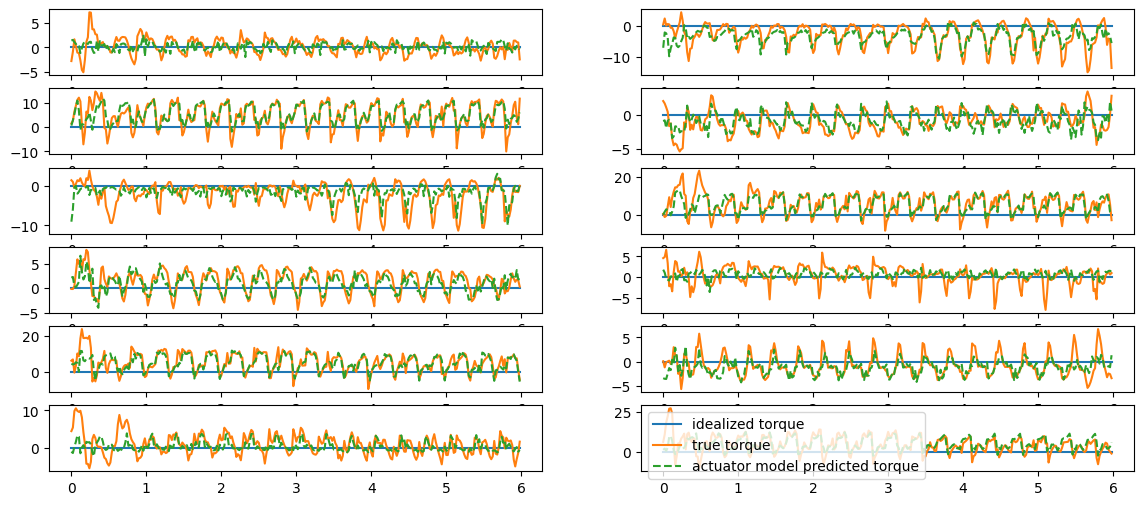

In [4]:
fig, axs = plt.subplots(6, 2, figsize=(14, 6))
axs = np.array(axs).flatten()
for i in range(12):
    axs[i].plot(timesteps_copy, torques_copy[:, i], label="idealized torque")
    axs[i].plot(timesteps_copy, tau_ests_copy[:, i], label="true torque")
    axs[i].plot(timesteps_copy, tau_preds_copy[:, i], linestyle='--', label="actuator model predicted torque")
    plt.legend()

plt.show()